In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
print ("Table 'measurement' has following columns:")
print(" ")

for col in columns:
    print (col['name'], col['type'])
print(" ")
print ("Table 'station' has following columns:")
print(" ")
columns = inspector.get_columns('station')
for col in columns:
    print (col['name'], col['type'])

Table 'measurement' has following columns:
 
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
 
Table 'station' has following columns:
 
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
import warnings
warnings.filterwarnings("ignore")

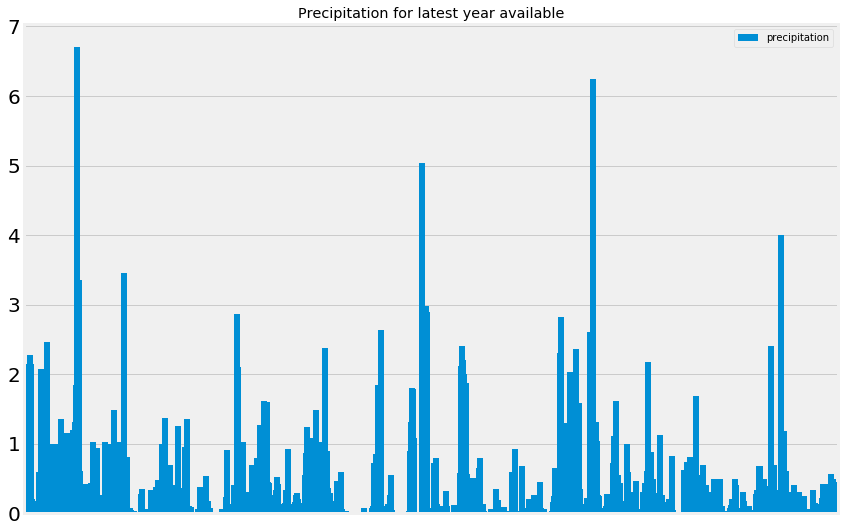

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
latest_date = dt.datetime.strptime(latest_date, '%Y-%m-%d').date()

# Calculate the date 1 year ago from the last data point in the database
year_ago = latest_date - dt.timedelta(days = 365)

# Perform a query to retrieve the data and precipitation scores
date_prcp = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_ago).statement

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.read_sql_query(date_prcp, session.bind)


# Sort the dataframe by date
df.sort_values(by=['date'], inplace = True)
df.set_index('date', inplace=True)
df.dropna(inplace=True)
df.rename(columns={'prcp':'precipitation'}, inplace = True)

# Use Pandas Plotting with Matplotlib to plot the data

df.plot.bar(title ="Precipitation for latest year available",figsize=(13,9),legend=True, width=15, grid=True)
ax1 = plt.axes()
x_axis = ax1.axes.get_xaxis()
x_axis.set_visible(False)
plt.yticks(fontsize=20)
plt.show()
plt.close()

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.name)).all()

[(9)]

In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

Text(0, 0.5, 'Frequency')

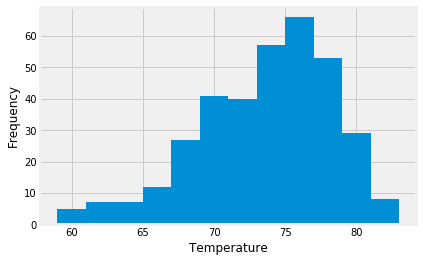

In [17]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

tobs_query = session.query(Measurement.tobs).filter(Measurement.date >= year_ago).\
    filter(Measurement.station == 'USC00519281').all()

tobs = list(np.ravel(tobs_query))
    
plt.hist(tobs, bins=12)
plt.xlabel("Temperature")  
plt.ylabel("Frequency")




In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))


[(62.0, 69.57142857142857, 74.0)]


In [19]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_begining_date = '2016-07-09'
trip_end_date = '2016-07-22'
temps = calc_temps(trip_begining_date, trip_end_date)
print(temps)

[(71.0, 77.34482758620689, 82.0)]


Text(0.5, 1.0, 'Trip Avg Temp')

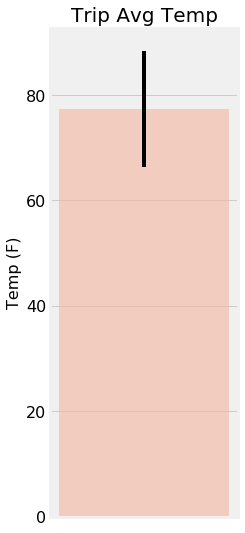

In [20]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

plt.figure(figsize=(3,9))
plt.bar("",temps[0][1], fc=(0.96, 0.71, 0.62, 0.6), yerr = temps[0][2] - temps[0][0] )
ax1 = plt.axes()
x_axis = ax1.axes.get_xaxis()
x_axis.set_visible(False)
plt.ylabel('Temp (F)', fontsize=16)
plt.yticks(fontsize=16)
plt.title("Trip Avg Temp", fontsize=20)

In [21]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

session.query(Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)).\
    group_by(Measurement.station).\
    filter(Measurement.date >= trip_begining_date).\
    filter(Measurement.date <= trip_end_date).\
    order_by(func.sum(Measurement.prcp).desc()).\
    filter(Measurement.station == Station.station).\
    all()

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  7.75),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  4.01),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  2.0900000000000003),
 ('USC00513117',
  'KANEOHE 838.1, HI US',
  21.4234,
  -157.8015,
  14.6,
  1.9300000000000002),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 1.85),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  1.6300000000000001),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.5)]

## Optional Challenge Assignment

In [22]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [23]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
from datetime import date, timedelta
# Set the start and end date of the trip
trip_begining_date = dt.date(2016, 7, 9)
trip_end_date = dt.date(2016, 7, 22)

# Use the start and end date to create a range of dates
date_list=[]
delta = trip_end_date - trip_begining_date        
for i in range(delta.days + 1):
    date_list.append(trip_begining_date + timedelta(i))


# Stip off the year and save a list of %m-%d strings
dates = [x.strftime("%m-%d") for x in date_list]

# Loop through the list of %m-%d strings and calculate the normals for each date
data = []
for y in dates:
    data.extend(daily_normals(y))
data

[(68.0, 76.19298245614036, 83.0),
 (68.0, 75.62068965517241, 82.0),
 (70.0, 75.78947368421052, 81.0),
 (67.0, 75.96491228070175, 82.0),
 (69.0, 76.1896551724138, 81.0),
 (61.0, 76.2280701754386, 82.0),
 (68.0, 76.2542372881356, 82.0),
 (70.0, 76.34482758620689, 83.0),
 (70.0, 76.30188679245283, 83.0),
 (72.0, 76.63793103448276, 83.0),
 (68.0, 75.89090909090909, 83.0),
 (69.0, 75.46296296296296, 82.0),
 (69.0, 76.9245283018868, 83.0),
 (69.0, 75.78846153846153, 81.0)]

In [24]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df_data = pd.DataFrame(data, columns = ['tmin','tavg','tmax'])
df_data['date'] = date_list
df_data.set_index('date', inplace=True)
df_data.head()

,tmin,tavg,tmax
date,,,
2016-07-09,68.0,76.192982,83.0
2016-07-10,68.0,75.620690,82.0
2016-07-11,70.0,75.789474,81.0
2016-07-12,67.0,75.964912,82.0
2016-07-13,69.0,76.189655,81.0


Text(0.5, 1.0, 'Minimum, Average and Maximum temperatures')

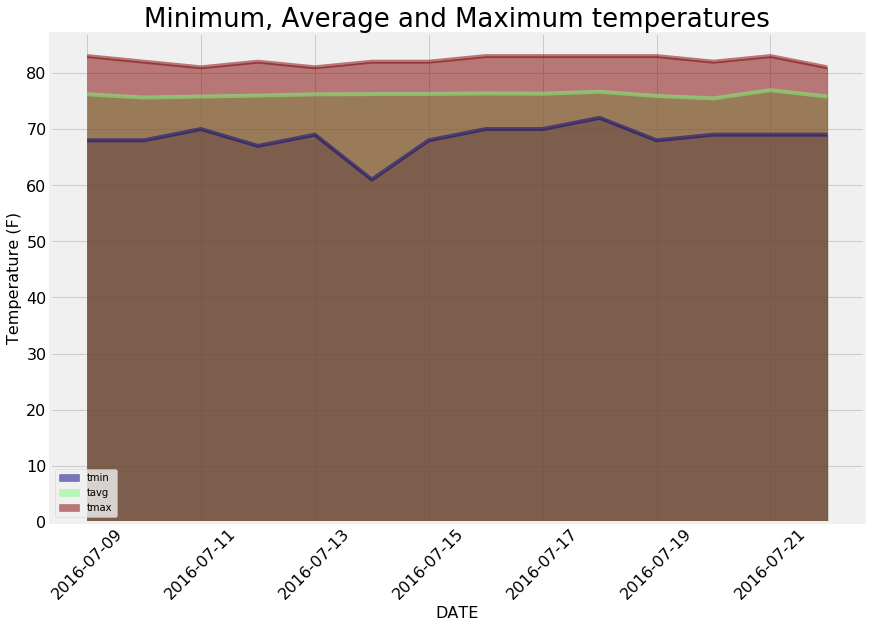

In [25]:
# Plot the daily normals as an area plot with `stacked=False`

df_data.plot(kind='area', stacked=False, alpha=0.5, colormap='jet', figsize=(13,9))
plt.xticks(rotation=45, fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('Temperature (F)', fontsize=16)
plt.xlabel('DATE', fontsize=16)
plt.title('Minimum, Average and Maximum temperatures', fontsize=26)